## LLM Integration & Routing with Structured Output

### Twitter - Social Media Customer Support Agent 

Learning Objectives:
- Integrate LLMs into LangGraph workflows
- Use Pydantic BaseModel for structured outputs with with_structured_output()
- Implement conditional routing based on sentiment

Prerequisites:
- Ollama installed and running (http://localhost:11434)
- qwen3 model downloaded: ollama pull qwen3


#### Real-World Applications:

1. Customer Service: Route tickets by urgency/sentiment with appropriate responses
2. Content Moderation: Binary classification (approved/flagged) with confidence
3. Email Response: Generate tone-appropriate replies based on sentiment strength
4. Review Analysis: Classify and respond to product reviews with matching intensity
5. Social Media Management: Brand-appropriate responses scaled to sentiment

In [19]:
from typing_extensions import TypedDict, Literal
from langgraph.graph import StateGraph, START, END
from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage, SystemMessage
from pydantic import BaseModel, Field


# Configuration
BASE_URL = "http://localhost:11434"
MODEL_NAME = "qwen3"


In [20]:
# =============================================================================
# Pydantic Model for Structured Output
# =============================================================================

class SentimentAnalysis(BaseModel):
    """Pydantic model for structured LLM output"""
    # Restrict to only positive/negative using Literal
    sentiment: Literal["positive", "negative"] = Field(description="The sentiment classification")

    # Validate confidence is between 0.0 and 1.0
    confidence: float = Field(ge=0.0, le=1.0, description="Confidence score from 0.0 to 1.0")
    
    reason: str = Field(description="Brief explanation")


In [21]:
# =============================================================================
# State Definition
# =============================================================================

class SentimentState(TypedDict):
    original_tweet: str
    sentiment: str
    confidence: float
    
    response_tweet: str



In [22]:
# =============================================================================
# Nodes
# =============================================================================

def analyze_sentiment(state: SentimentState):
    """Analyze sentiment using structured output."""
    tweet = state["original_tweet"]
    print(f"\n[ANALYZE] {tweet}")

    # Initialize LLM
    llm = ChatOllama(model=MODEL_NAME, base_url=BASE_URL, temperature=0.7)
    # Enable structured output with Pydantic model
    llm_structured = llm.with_structured_output(SentimentAnalysis)

    messages = [
        SystemMessage(content="""Analyze sentiment and provide structured output.
                                Use 0.0-1.0 scale: lower = negative, higher = positive"""),
        HumanMessage(content=tweet)
    ]

    # Get validated Pydantic object back (no manual parsing!)
    analysis = llm_structured.invoke(messages)

    print(f"[RESULT] {analysis.sentiment.upper()} (confidence: {analysis.confidence:.2f})")

    # Return dict for state update
    return {
        "sentiment": analysis.sentiment,
        "confidence": analysis.confidence
    }


In [23]:
def generate_positive_response(state: SentimentState):
    """Generate positive response."""
    print(f"\n[POSITIVE] Generating response...")

    llm = ChatOllama(model=MODEL_NAME, base_url=BASE_URL, temperature=0.7)
    
    messages = [
        SystemMessage(content=f"""Generate a warm response to this positive tweet (under 280 chars).
                                    Confidence: {state['confidence']:.2f}
                                    - High confidence (>0.7): Be enthusiastic
                                    - Low confidence (<0.7): Be friendly"""),
        HumanMessage(content=state["original_tweet"])
    ]

    response = llm.invoke(messages)
    
    return {"response_tweet": response.content.strip()}


In [24]:
def generate_negative_response(state: SentimentState):
    """Generate negative response."""
    print(f"\n[NEGATIVE] Generating response...")

    llm = ChatOllama(model=MODEL_NAME, base_url=BASE_URL, temperature=0.7)
    
    messages = [
        SystemMessage(content=f"""Generate an empathetic response to this negative tweet (under 280 chars).
                                    Confidence: {state['confidence']:.2f}
                                    - Low confidence (<0.3): Be very empathetic
                                    - High confidence (>0.3): Be understanding"""),
        HumanMessage(content=state["original_tweet"])
    ]

    response = llm.invoke(messages)
    return {"response_tweet": response.content.strip()}


In [25]:
def route_by_sentiment(state: SentimentState):
    """Route based on sentiment."""
    print(f"[ROUTE] {state['sentiment'].upper()}")

    # Return the name of the next node to execute
    return "positive_response" if state["sentiment"] == "positive" else "negative_response"

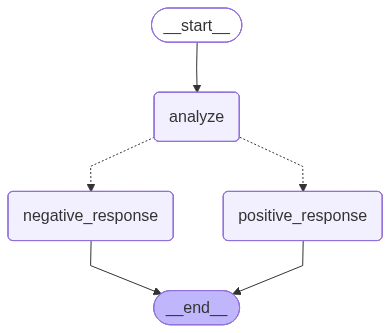

In [ ]:
# =============================================================================
# Graph
# =============================================================================

def create_agent():
    """Create the sentiment analysis graph."""
    # Create graph with our state schema
    builder = StateGraph(SentimentState)

    # Add nodes (functions that process state)
    builder.add_node("analyze", analyze_sentiment)
    builder.add_node("positive_response", generate_positive_response)
    builder.add_node("negative_response", generate_negative_response)

    # Define edges (flow between nodes)
    builder.add_edge(START, "analyze")
    # Conditional edge: route based on sentiment
    # builder.add_conditional_edges("analyze", route_by_sentiment)
    builder.add_conditional_edges("analyze", 
                                route_by_sentiment,
                                ["positive_response", "negative_response"])
    
    builder.add_edge("positive_response", END)
    builder.add_edge("negative_response", END)

    # Compile into runnable graph
    return builder.compile()

graph = create_agent()

graph

In [27]:
test_tweets = [
        "Just launched my new product! The response has been incredible!",
        "Really disappointed with the customer service today."
    ]

In [28]:
for tweet in test_tweets:
        print("\n" + "=" * 70)
        result = graph.invoke({
            "original_tweet": tweet,
            "sentiment": "",
            "response_tweet": "",
            "confidence": 0.0
        })
        print(f"\n[RESPONSE] {result['response_tweet']}")



[ANALYZE] Just launched my new product! The response has been incredible!
[RESULT] POSITIVE (confidence: 0.98)
[ROUTE] POSITIVE

[POSITIVE] Generating response...

[RESPONSE] Wow, that's amazing! Your dedication is paying off! You're making a real impact! Can't wait to see where this goes! 🚀


[ANALYZE] Really disappointed with the customer service today.
[RESULT] NEGATIVE (confidence: 0.95)
[ROUTE] NEGATIVE

[NEGATIVE] Generating response...

[RESPONSE] I'm sorry to hear about your experience. I understand how frustrating that can be. Is there anything I can do to help?
